In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import keras
from keras.initializers import he_normal
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, MaxPooling1D, Flatten, Embedding, Input
from keras.layers.convolutional import Conv1D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping
from tensorboard.plugins.pr_curve import summary as pr_summary

%matplotlib inline

/Users/tim/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data Exploration

In [2]:
dataset = '../../datasets/heli_uniform/hs_ds1_1m_uniform.csv' # Uniform sampling

In [ ]:
dataset = '../../datasets/heli_dynamics/hc_dynaware_200k.csv' # Dynamics aware sampling

In [74]:
dataset = '../../datasets/heli_uniform/hc_uniform_100k_var_t.csv' # Uniform with varying T

In [75]:
data = pd.read_csv(dataset, header=None)

In [ ]:
data.hist(grid=False, figsize=(15,40), layout=(10,3), bins=100)

In [25]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,-6.8999,-8.37400,5.13050,-8.0609,-9.33130,-105.830,101.54,16.855,6.8871,11.7080,...,7.5461,24.5830,8.607700,-2.8798,-12.6510,8.0613,31.0720,27.940,4.3402,0
1,-4.5357,-0.52922,18.42200,-7.9649,0.81289,-115.480,-243.84,-15.475,-7.0315,2.2563,...,-3.3797,-12.4200,0.081632,10.3430,26.7400,10.4490,3.0813,52.084,5.7360,1
2,2.5017,-4.42380,0.87547,-3.3952,-4.49810,-76.253,340.43,50.671,-2.1604,13.8310,...,2.3620,-19.0510,-5.757100,9.1906,-23.4770,5.3194,-21.3580,37.179,5.8575,0
3,-4.9772,4.38300,-7.15340,-9.2472,6.23720,-272.810,-141.73,-39.216,1.4554,-15.1920,...,-3.6111,-2.8229,0.664370,8.5014,-5.2599,12.2940,-26.5540,87.247,6.8625,1
4,-1.3701,-7.25670,-19.26300,-2.6852,-9.65380,-17.134,-257.84,68.971,18.2960,-12.1550,...,-9.9964,18.6000,8.061400,-1.7804,-8.0499,-4.0558,-14.8490,83.509,9.7829,1


In [76]:
X = data.drop(data.columns[30], axis=1)
y = data[data.columns[30]]

In [83]:
# Normalize
X = X.apply(zscore)
(num_samples, num_features) = X.shape
print (num_samples, num_features)

(100000, 30)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x102d5fc50>,
      dtype=object)

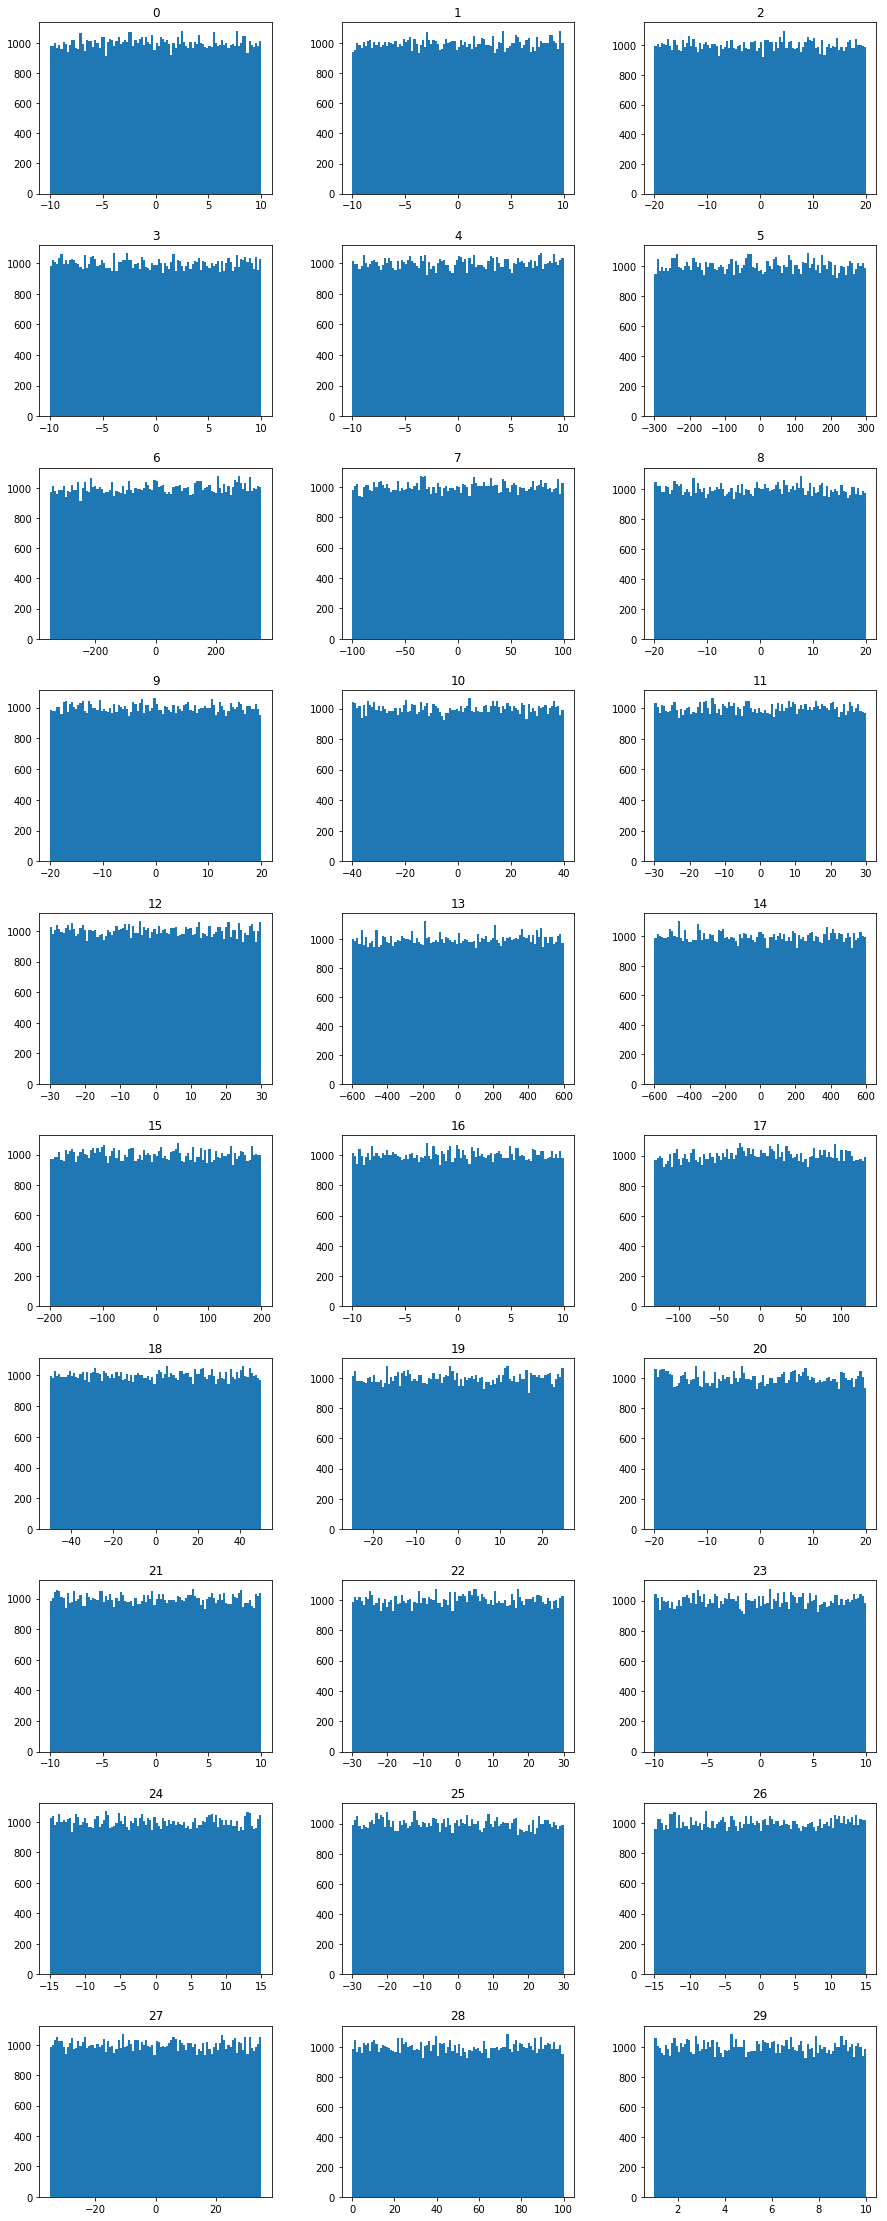

In [27]:
X.hist(grid=False, figsize=(15,40), layout=(10,3), bins=100, sharex=False)

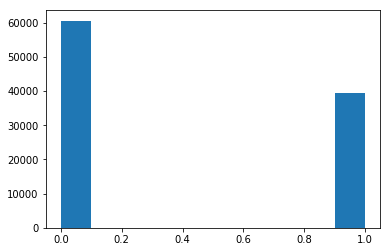

In [29]:
y.hist(grid=False)

In [30]:
X = X.drop(X.columns[29], axis=1)
num_features = num_features - 1

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

# TensorBoard Visualization

Displays Precision-Recall curve for Keras models.

Adapted from: https://medium.com/@akionakas/precision-recall-curve-with-keras-cd92647685e1

In [7]:
class PRTensorBoard(TensorBoard):
    def __init__(self, *args, **kwargs):
        # One extra argument to indicate whether or not to use the PR curve summary.
        self.pr_curve = kwargs.pop('pr_curve', True)
        super(PRTensorBoard, self).__init__(*args, **kwargs)

        global tf
        import tensorflow as tf

    def set_model(self, model):
        super(PRTensorBoard, self).set_model(model)

        if self.pr_curve:
            # Get the prediction and label tensor placeholders.
            predictions = self.model._feed_outputs[0]
            labels = tf.cast(self.model._feed_targets[0], tf.bool)
            # Create the PR summary OP.
            self.pr_summary = pr_summary.op(name='pr_curve',
                                            predictions=predictions,
                                            labels=labels,
                                            display_name='Precision-Recall Curve')

    def on_epoch_end(self, epoch, logs=None):
        super(PRTensorBoard, self).on_epoch_end(epoch, logs)

        if self.pr_curve and self.validation_data:
            # Get the tensors again.
            tensors = self.model._feed_targets + self.model._feed_outputs
            # Predict the output.
            predictions = self.model.predict(self.validation_data[0])
            # Build the dictionary mapping the tensor to the data.
            val_data = [self.validation_data[1], predictions]
            feed_dict = dict(zip(tensors, val_data))
            # Run and add summary.
            result = self.sess.run([self.pr_summary], feed_dict=feed_dict)
            self.writer.add_summary(result[0], epoch)
        self.writer.flush()

# DNN

In [93]:
epochs = 20
batch_size = 32

model = Sequential()
model.add(Dense(30, input_dim=num_features))
model.add(Activation('tanh'))

model.add(Dense(30))
model.add(Activation('tanh'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [94]:
opt = keras.optimizers.Adagrad()

model.compile(loss = 'mean_squared_error',
              optimizer = opt,
              metrics = ['accuracy'])

In [95]:
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=.2,
          shuffle=True,
          callbacks=[EarlyStopping(monitor='val_acc', patience=2)])

Train on 64000 samples, validate on 16000 samples
Epoch 1/20
64000/64000 [==============================] - 6s 98us/step - loss: 0.0861 - acc: 0.8804 - val_loss: 0.0855 - val_acc: 0.8813
Epoch 2/20
64000/64000 [==============================] - 5s 82us/step - loss: 0.0825 - acc: 0.8854 - val_loss: 0.0845 - val_acc: 0.8836
Epoch 3/20
64000/64000 [==============================] - 5s 78us/step - loss: 0.0813 - acc: 0.8872 - val_loss: 0.0834 - val_acc: 0.8847
Epoch 4/20
64000/64000 [==============================] - 5s 76us/step - loss: 0.0797 - acc: 0.8891 - val_loss: 0.0814 - val_acc: 0.8872
Epoch 5/20
64000/64000 [==============================] - 5s 77us/step - loss: 0.0771 - acc: 0.8927 - val_loss: 0.0781 - val_acc: 0.8914
Epoch 6/20
64000/64000 [==============================] - 5s 78us/step - loss: 0.0730 - acc: 0.8990 - val_loss: 0.0732 - val_acc: 0.8979
Epoch 7/20
64000/64000 [==============================] - 5s 76us/step - loss: 0.0679 - acc: 0.9074 - val_loss: 0.0679 - val_acc

In [89]:
score = model.evaluate(X_test, y_test, batch_size=batch_size)
print model.metrics_names
print score

20000/20000 [==============================] - 1s 43us/step
['loss', 'acc']
[0.037390116529352965, 0.9477]


# Uniform Sampling CNN Model

We are interested in plotting the learning curves for the uniform dataset.  To do this we will keep the test data fixed and vary the size of the training data.

In [158]:
# Remove a percentage (test_size) of the data from the training set (hold test set constant)
X_train_sub, X_ignore, y_train_sub, y_ignore = train_test_split(X_train, y_train, test_size=0.8, random_state=42, shuffle=False)

In [96]:
X_train_sub = X_train
y_train_sub = y_train

In [97]:
epochs = 20
batch_size = 32
X_train_cnn = np.expand_dims(X_train_sub.as_matrix(), axis=2)
X_test_cnn = np.expand_dims(X_test.as_matrix(), axis=2)

In [102]:
# 16 3x1 convolutions
inputs = Input(shape=(num_features, 1))
conv1 = Conv1D(16, 5, padding='same', strides=1, kernel_initializer=he_normal(seed=None))(inputs)
bn1 = BatchNormalization()(conv1)
relu1 = Activation('relu')(bn1)

# 32 3x16 convolutions
conv2 = Conv1D(32, 3, padding='same', strides=1, kernel_initializer=he_normal(seed=None))(relu1)
bn2 = BatchNormalization()(conv2)
relu2 = Activation('relu')(bn2)
flatten = Flatten()(relu2)

# FC 2048
fc1 = Dense(256, kernel_initializer=he_normal(seed=None))(flatten)
bn3 = BatchNormalization()(fc1)
relu3 = Activation('relu')(bn3)
drop1 = Dropout(0.75)(relu3)

# FC 1024
fc2 = Dense(128, kernel_initializer=he_normal(seed=None))(drop1)
bn4 = BatchNormalization()(fc2)
relu4 = Activation('relu')(bn4)
drop2 = Dropout(0.75)(relu4)

# FC 512
fc3 = Dense(128, kernel_initializer=he_normal(seed=None))(drop2)
bn5 = BatchNormalization()(fc3)
relu5 = Activation('relu')(bn5)
drop3 = Dropout(0.75)(relu5)

# Output
fc4 = Dense(1, kernel_initializer=he_normal(seed=None))(drop3)
outputs = Activation('sigmoid')(fc4)

model = Model(inputs=inputs, outputs=outputs)

In [103]:
opt = keras.optimizers.Adagrad()

model.compile(loss = 'binary_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])

In [104]:
model.fit(X_train_cnn, y_train_sub,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=.2,
          shuffle=True,
          callbacks=[EarlyStopping(monitor='val_acc', patience=2)])

Train on 64000 samples, validate on 16000 samples
Epoch 1/20
64000/64000 [==============================] - 27s 429us/step - loss: 0.4303 - acc: 0.7948 - val_loss: 0.2683 - val_acc: 0.8929
Epoch 2/20
64000/64000 [==============================] - 25s 384us/step - loss: 0.3122 - acc: 0.8676 - val_loss: 0.2252 - val_acc: 0.9116
Epoch 3/20
64000/64000 [==============================] - 28s 433us/step - loss: 0.2800 - acc: 0.8827 - val_loss: 0.1976 - val_acc: 0.9262
Epoch 4/20
64000/64000 [==============================] - 27s 415us/step - loss: 0.2623 - acc: 0.8903 - val_loss: 0.1805 - val_acc: 0.9324
Epoch 5/20
64000/64000 [==============================] - 25s 384us/step - loss: 0.2562 - acc: 0.8931 - val_loss: 0.1728 - val_acc: 0.9374
Epoch 6/20
64000/64000 [==============================] - 25s 391us/step - loss: 0.2437 - acc: 0.9005 - val_loss: 0.1651 - val_acc: 0.9388
Epoch 7/20
64000/64000 [==============================] - 25s 390us/step - loss: 0.2390 - acc: 0.9015 - val_loss: 0.

In [101]:
score = model.evaluate(X_test_cnn, y_test, batch_size=batch_size)
print model.metrics_names
print score

20000/20000 [==============================] - 3s 144us/step
['loss', 'acc']
[0.11317532860934734, 0.96]


[(20%, 8, 0.975895), (40%, 5, 0.976265), (60%, 5, 0.979475), (80%, 5, 0.98054), (100%, 3, 0.986735)]

In [ ]:
model.save('models/uniform/cnn_40_percent.h5')

## Dynamics Aware Test Set

We are interested in seeing how well our models trained on the Uniform dataset generalize to the Dymanics Aware data.  For this we will simply use the Dynamics Aware dataset as our test set.

In [ ]:
data = pd.read_csv('../../datasets/heli_dynamics/hc_dynaware_200k.csv', header=None)

In [ ]:
X_test = data.drop(data.columns[29], axis=1)
X_test = X_test.apply(zscore)
X_test_cnn = np.expand_dims(X_test.as_matrix(), axis=2)

y_test = data[data.columns[29]]

In [ ]:
X_test.hist(grid=False, figsize=(15,40), layout=(10,3), bins=100)

In [ ]:
y_test.hist(grid=False)

In [ ]:
score = model.evaluate(X_test_cnn, y_test, batch_size=batch_size)
print model.metrics_names
print score

[(20%, 0.63983), (40%, ), (60%, ), (80%, ), (100%, )]

# Dynamics Aware CNN Model

In [ ]:
epochs = 10
batch_size = 32
X_train_cnn = np.expand_dims(X_train.as_matrix(), axis=2)
X_test_cnn = np.expand_dims(X_test.as_matrix(), axis=2)

In [ ]:
# 16 3x1 convolutions
inputs = Input(shape=(num_features, 1))
conv1 = Conv1D(16, 3, padding='same', strides=1, kernel_initializer=he_normal(seed=None))(inputs)
bn1 = BatchNormalization()(conv1)
relu1 = Activation('relu')(bn1)

# 32 3x16 convolutions
conv2 = Conv1D(32, 3, padding='same', strides=1, kernel_initializer=he_normal(seed=None))(relu1)
bn2 = BatchNormalization()(conv2)
relu2 = Activation('relu')(bn2)
flatten = Flatten()(relu2)

# FC 2048
fc1 = Dense(2048, kernel_initializer=he_normal(seed=None))(flatten)
bn3 = BatchNormalization()(fc1)
relu3 = Activation('relu')(bn3)
drop1 = Dropout(0.5)(relu3)

# FC 1024
fc2 = Dense(1024, kernel_initializer=he_normal(seed=None))(drop1)
bn4 = BatchNormalization()(fc2)
relu4 = Activation('relu')(bn4)
drop2 = Dropout(0.5)(relu4)

# FC 512
fc3 = Dense(512, kernel_initializer=he_normal(seed=None))(drop2)
bn5 = BatchNormalization()(fc3)
relu5 = Activation('relu')(bn5)
drop3 = Dropout(0.5)(relu5)

# Output
fc4 = Dense(1, kernel_initializer=he_normal(seed=None))(drop3)
outputs = Activation('sigmoid')(fc4)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
#opt = keras.optimizers.Adadelta()
opt = keras.optimizers.Adagrad()

model.compile(loss = 'binary_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])

In [ ]:
model.fit(X_train_cnn, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=.2,
          shuffle=True,
          callbacks=[PRTensorBoard(log_dir='logs/dyn'), EarlyStopping(monitor='val_acc', patience=2)])

In [ ]:
score = model.evaluate(X_test_cnn, y_test, batch_size=batch_size)
print model.metrics_names
print score

In [ ]:
model.save('models/dynamics/cnn.h5')